## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

## Helper Functions

In [2]:
# summary table function
def summary(df):
    print('Data Shape:', df.shape)
    table = pd.DataFrame(df.dtypes, columns=['data type'])
    table['No. of missing values'] = df.isnull().sum().values
    table['% of missing values'] = df.isnull().sum().values / len(df)* 100
    table['No. of unique values'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').T)
    table['mean'] = desc['mean'].values
    table['std'] = desc['std'].values
    table['min'] = desc['min'].values
    table['max'] = desc['max'].values
    table['first quartile'] = desc.loc[:, '25%'].values
    table['second quartile'] = desc.loc[:, '50%'].values
    table['third quartile'] = desc.loc[:, '75%'].values

    return table

def plot_roc_pr(model, x_test, y_test):
    preds = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, pred_prob[:,1])
    prec, recall, _ = precision_recall_curve(y_test, pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, prec)
    roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
    pr_display = PrecisionRecallDisplay(precision = prec, recall = recall)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    roc_display.plot(ax=ax1)
    ax1.set_title("ROC Curve")
    pr_display.plot(ax=ax2)
    ax2.set_title("Precision-Recall Curve")
    plt.show()

def roc_cutoff(model, x_test, y_test):
    preds = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1])
    optimal_idx = np.argmin((1 - tpr) ** 2 + fpr ** 2)
    optimal_thresh = thresh[optimal_idx]
    return optimal_thresh

def plot_feature_importance(x, model, Model_name):
    plt.figure(figsize=(8,8))
    feature_imp = pd.Series(model.feature_importances_, index = x.columns.values).sort_values()
    plt.barh(feature_imp.index, feature_imp)
    plt.xticks(rotation=45);
    plt.title('Feature Importance'+ Model_name)
    plt.xlabel('Feature Importance (%)')
    plt.show()

## EDA

In [3]:
train = pd.read_csv('Data\\train.csv')
train.head()

Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]

In [4]:
summary(train)

Data Shape: (617, 58)


data type  No. of missing values  % of missing values  \
Id       object                      0             0.000000   
AB      float64                      0             0.000000   
AF      float64                      0             0.000000   
AH      float64                      0             0.000000   
AM      float64                      0             0.000000   
AR      float64                      0             0.000000   
AX      float64                      0             0.000000   
AY      float64                      0             0.000000   
AZ      float64                      0             0.000000   
BC      float64                      0             0.000000   
BD      float64                      0             0.000000   
BN      float64                      0             0.000000   
BP      float64                      0             0.000000   
BQ      float64                     60             9.724473   
BR      float64                      0             0.000000   
BZ      float64                      0             0.000000   
CB      float64                      2             0.324149   
CC      float64                      3             0.486224   
CD      float64                      0             0.000000   
CF      float64                      0             0.000000   
CH      float64                      0             0.000000   
CL      float64                      0             0.000000   
CR      float64                      0             0.000000   
CS      float64                      0             0.000000   
CU      float64                      0             0.000000   
CW      float64                      0             0.000000   
DA      float64                      0             0.000000   
DE      float64                      0             0.000000   
DF      float64                      0             0.000000   
DH      float64                      0             0.000000   
DI      float64                      0             0.000000   
DL      float64                      0             0.000000   
DN      float64                      0             0.000000   
DU      float64                      1             0.162075   
DV      float64                      0             0.000000   
DY      float64                      0             0.000000   
EB      float64                      0             0.000000   
EE      float64                      0             0.000000   
EG      float64                      0             0.000000   
EH      float64                      0             0.000000   
EJ       object                      0             0.000000   
EL      float64                     60             9.724473   
EP      float64                      0             0.000000   
EU      float64                      0             0.000000   
FC      float64                      1             0.162075   
FD      float64                      0             0.000000   
FE      float64                      0             0.000000   
FI      float64                      0             0.000000   
FL      float64                      1             0.162075   
FR      float64                      0             0.000000   
FS      float64                      2             0.324149   
GB      float64                      0             0.000000   
GE      float64                      0             0.000000   
GF      float64                      0             0.000000   
GH      float64                      0             0.000000   
GI      float64                      0             0.000000   
GL      float64                      1             0.162075   
Class     int64                      0             0.000000   

       No. of unique values          mean           std          min  \
Id                      617           NaN           NaN          NaN   
AB                      217      0.477149      0.468388     0.081187   
AF                      599   3502.013221   2300.322717    192.59328   


In [5]:
pie_class = px.pie(train, names='Class', height=400, width=600, title='Distribution of Target (Class)', color_discrete_sequence=['Gray', 'Teal'])

pie_class.show()

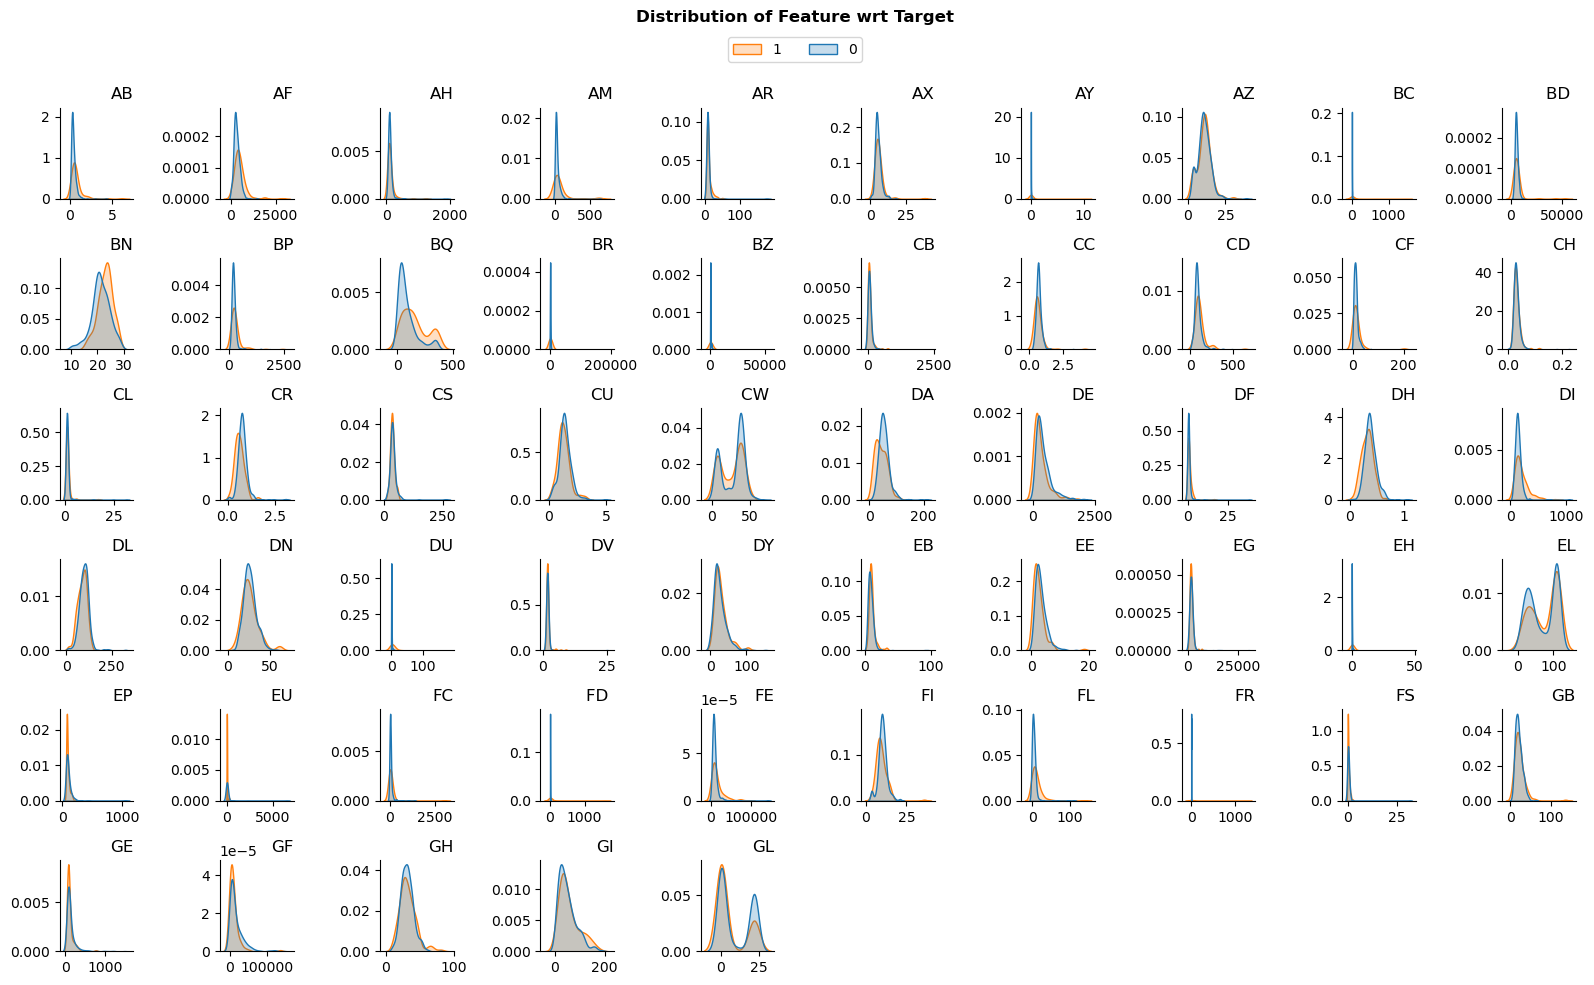

In [6]:
num_cols = train.select_dtypes(include=['float64']).columns.tolist()
fig = plt.figure(figsize = (16, 10))
for idx, col in enumerate(num_cols):
    ax = plt.subplot(6,10, idx + 1)
    sns.kdeplot(
        data=train, common_norm = False, hue='Class', fill=True,
        x=col, cmap = 'viridis', legend=False
    )

    ax.set_ylabel(''); ax.spines['top'].set_visible(False),
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right')

fig.suptitle(f'Distribution of Feature wrt Target\n\n\n', ha='center',  fontweight='bold')
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
plt.tight_layout()
plt.show()

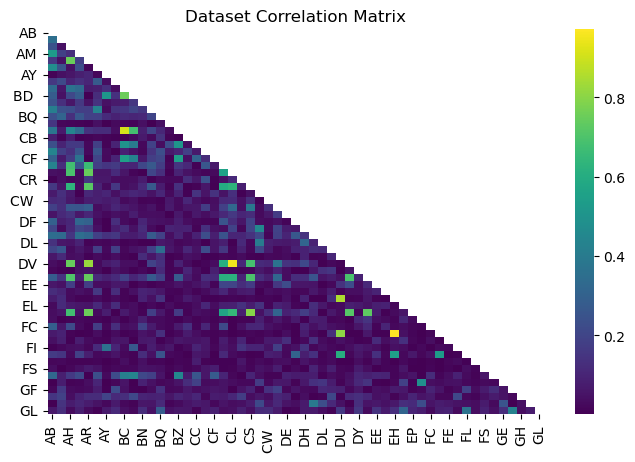

In [7]:
# Absolute correlation matrix
corr = train.corr(numeric_only = True).abs()
plt.figure(figsize = (8, 5))
mask = np.zeros_like(corr.iloc[:-1, :-1])
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr.iloc[:-1, :-1], mask = mask, cmap = 'viridis')
# sns.clustermap(corr.iloc[:-1, :-1], metric="correlation", cmap = 'viridis')
plt.title('Dataset Correlation Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>

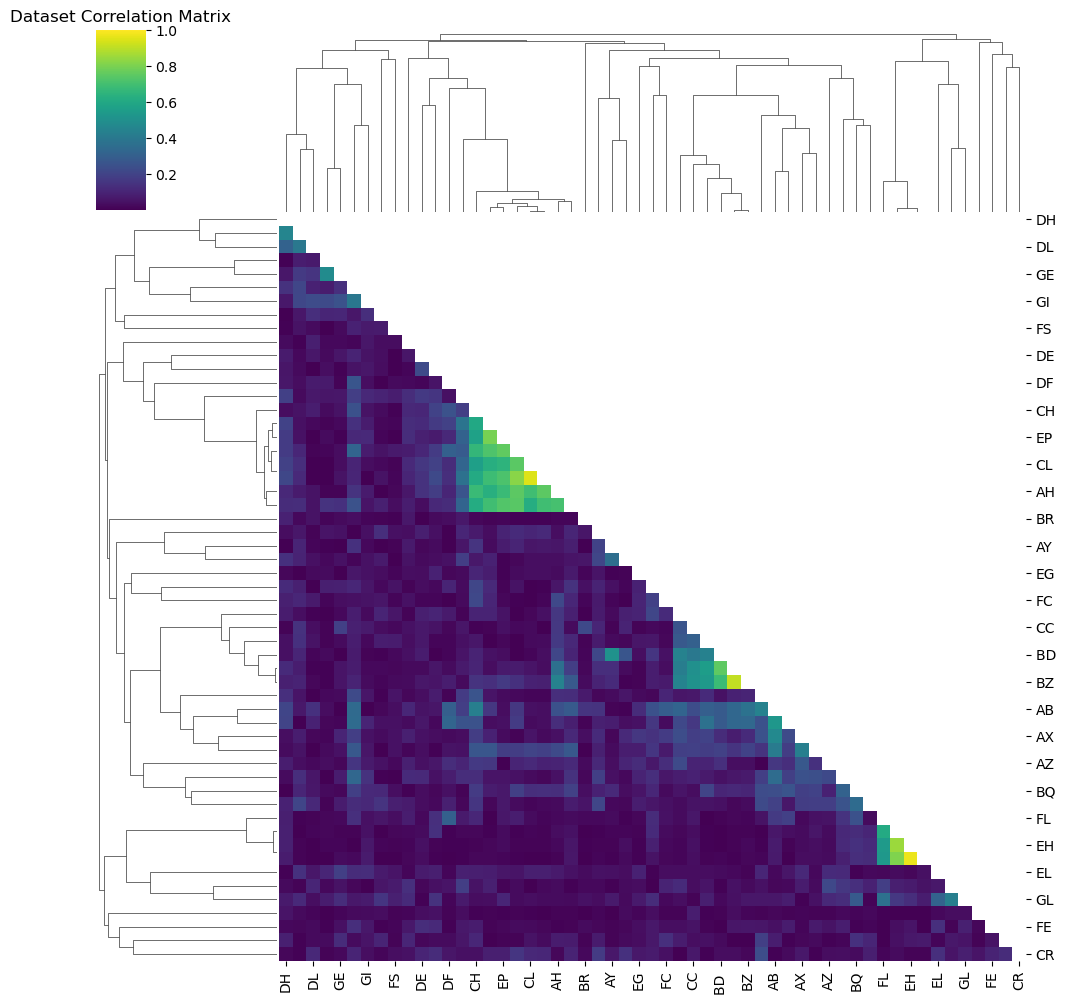

In [8]:
plt.figure(figsize = (10, 8))
fig = sns.clustermap(corr.iloc[:-1, :-1], metric="correlation", cmap = 'viridis')
mask = np.triu(np.ones_like(corr.iloc[:-1, :-1]))
values = fig.ax_heatmap.collections[0].get_array().reshape(corr.iloc[:-1, :-1].shape)
new_values = np.ma.array(values, mask=mask)
fig.ax_heatmap.collections[0].set_array(new_values)

plt.title('Dataset Correlation Matrix')
plt.show()

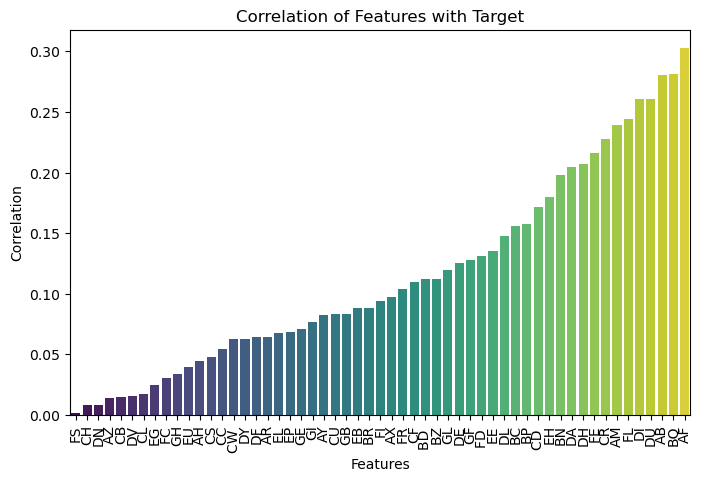

In [9]:
corr_target = corr["Class"].sort_values()[:-1]

# create a bar plot to visualize the correlation
plt.figure(figsize=(8,5))
sns.barplot(x=corr_target.index, y=corr_target.values, palette = 'viridis')
plt.xticks(rotation=90)
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation")
plt.xlabel("Features")
plt.show()

## Data Preprocessing

In [10]:
train = train.drop(['Id'], axis=1)
train["EJ"].replace({"A": 0, "B": 1}, inplace=True)

### Imputing Missing Values

In [11]:
nullCols = list(train.columns[train.isna().sum() != 0])
train[nullCols].isna().sum()

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [12]:
null_mean_fill = []
null_knn_fill = []

null_count = train[nullCols].isna().sum()
for column in nullCols:
    if null_count[column] <= 2:
        null_mean_fill.append(column)
    else:
        null_knn_fill.append(column)

null_mean_fill, null_knn_fill

(['CB', 'DU', 'FC', 'FL', 'FS', 'GL'], ['BQ', 'CC', 'EL'])

In [13]:
simple_imputer = SimpleImputer(strategy="mean")
knn_imputer = KNNImputer(n_neighbors=5)

train_imp = train.copy()
train_imp[null_mean_fill] = simple_imputer.fit_transform(train_imp[null_mean_fill])
train_imp[null_knn_fill] = knn_imputer.fit_transform(train_imp[null_knn_fill])

In [14]:
train_imp.isna().sum().sum()

0

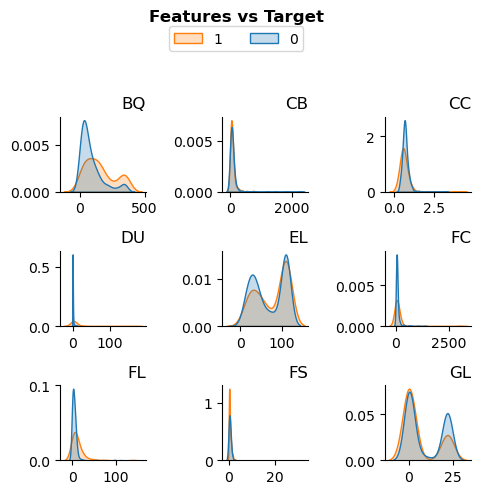

In [15]:
fig = plt.figure(figsize = (5, 5))
for idx, col in enumerate(nullCols):
    ax = plt.subplot(3,3, idx + 1)
    sns.kdeplot(
        data=train, common_norm = False, hue='Class', fill=True,
        x=col, cmap = 'viridis', legend=False
    )

    ax.set_ylabel(''); ax.spines['top'].set_visible(False),
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right')

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold')
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
plt.tight_layout()
plt.show()

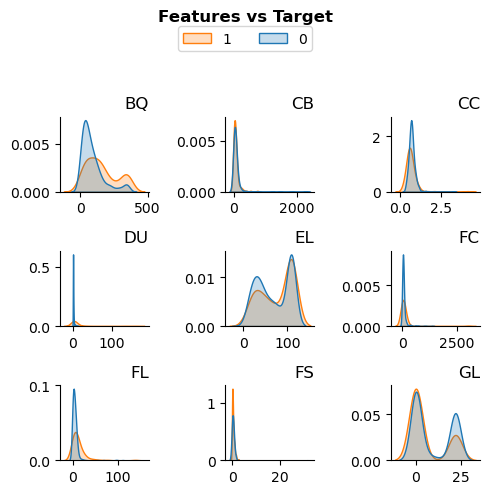

In [16]:
fig = plt.figure(figsize = (5, 5))
for idx, col in enumerate(nullCols):
    ax = plt.subplot(3,3, idx + 1)
    sns.kdeplot(
        data=train_imp, common_norm = False, hue='Class', fill=True,
        x=col, cmap = 'viridis', legend=False
    )

    ax.set_ylabel(''); ax.spines['top'].set_visible(False),
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right')

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold')
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
plt.tight_layout()
plt.show()

### Scaling Data

In [17]:
train_imp[num_cols] = StandardScaler().fit_transform(train_imp[num_cols])

In [18]:
# fig = plt.figure(figsize = (15, 15))
# for idx, col in enumerate(num_cols):
#     ax = plt.subplot(11,5, idx + 1)
#     sns.kdeplot(
#         data=train_imp, common_norm = False, hue='Class', fill=True,
#         x=col, cmap = 'viridis', legend=False
#     )

#     ax.set_ylabel(''); ax.spines['top'].set_visible(False),
#     ax.set_xlabel(''); ax.spines['right'].set_visible(False)
#     ax.set_title(f'{col}', loc='right')

# fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold')
# fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
# plt.tight_layout()
# plt.show()

In [19]:
train_imp.columns = [c.strip(' ') for c in train_imp.columns]

In [20]:
X = train_imp.drop("Class" , axis = 1)
y = train_imp["Class"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 208, shuffle = True)

## Modeling

### Logistic Regression

In [21]:
lr = LogisticRegression(random_state = 208)
lr.fit(x_train,y_train)

preds = lr.predict(x_test)
pred_prob = lr.predict_proba(x_test)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.9466357308584686
0.8763440860215054


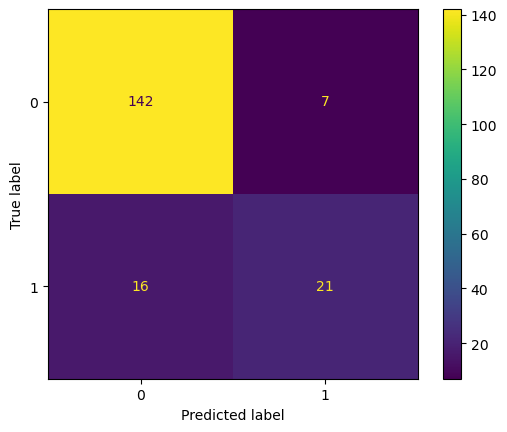

In [22]:
cm = confusion_matrix(y_test, preds, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr.classes_)
disp.plot()

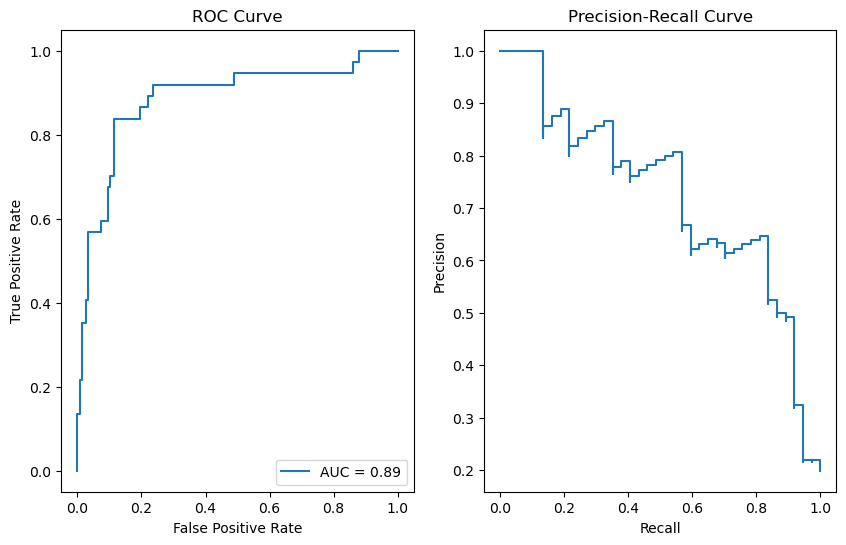

In [23]:
plot_roc_pr(lr, x_test, y_test)

0.19086436850119115


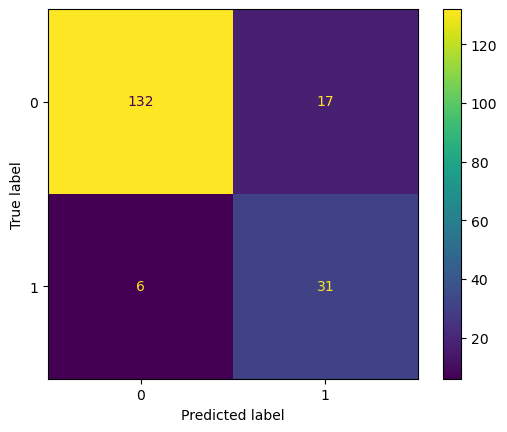

In [24]:
cutoff = roc_cutoff(lr, x_test, y_test)
print(cutoff)
y_pred = (lr.predict_proba(x_test)[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr.classes_)
disp.plot()

### Random Forest

In [25]:
rf_1 = RandomForestClassifier(random_state = 208, oob_score = True)
rf_1.fit(x_train, y_train)

preds = rf_1.predict(x_test)
pred_prob = rf_1.predict_proba(x_test)
print(rf_1.score(x_train, y_train))
print(rf_1.score(x_test, y_test))

1.0
0.8978494623655914


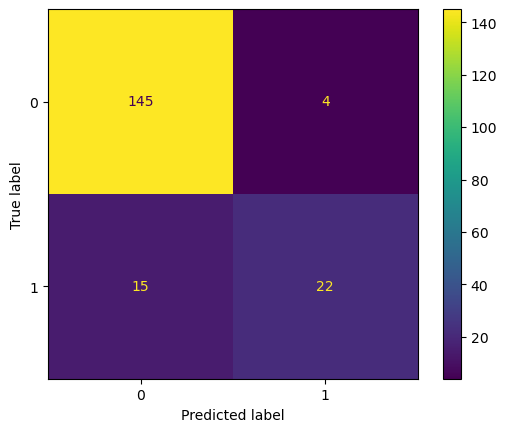

In [26]:
cm = confusion_matrix(y_test, rf_1.predict(x_test), labels = rf_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_1.classes_)
disp.plot()

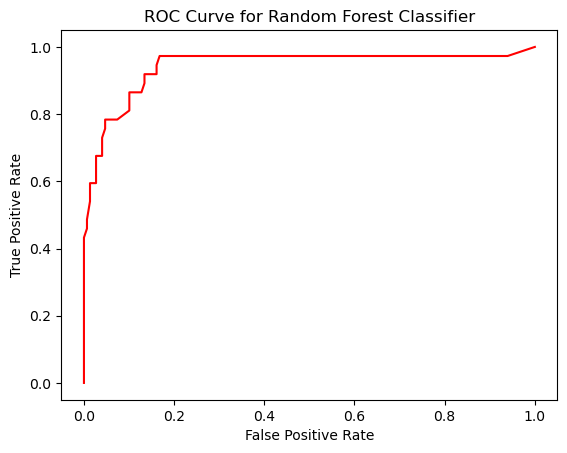

In [27]:
rf_1_fpr, rf_1_tpr, _ = roc_curve(y_test, pred_prob[:,1])

plt.plot(rf_1_fpr, rf_1_tpr, 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier');

In [28]:
# Number of trees in random forest
n_estimators = np.linspace(1500, 3000, int((3000-1000)/200) + 1, dtype=int)
# Maximum number of levels in tree
max_depth = [50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True]
# Criterion
criterion=['gini', 'entropy']
# Out of bag score
oob = [True]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'oob_score': oob}

rf_2 = RandomForestClassifier(random_state = 208)
rf_2_random = RandomizedSearchCV(estimator = rf_2,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5, refit = True,
                               verbose=2,
                               random_state = 208, n_jobs = -1, scoring = 'f1')
rf_2_random.fit(x_train, y_train)

preds = rf_2_random.predict(x_test)
print(rf_2_random.score(x_train, y_train))
print(rf_2_random.score(x_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.9929078014184397
0.6885245901639344


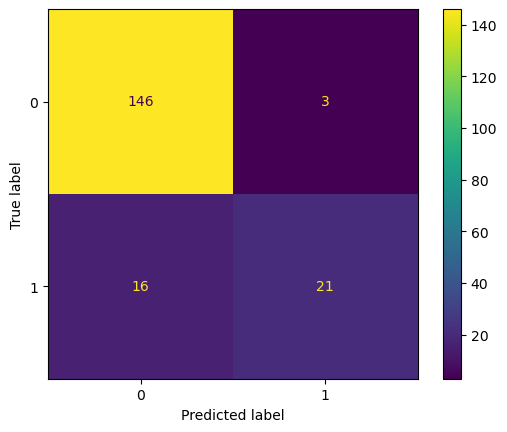

In [29]:
cm = confusion_matrix(y_test, rf_2_random.predict(x_test), labels = rf_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_2_random.classes_)
disp.plot()

In [30]:
rf_2_random.best_params_

{'oob_score': True,
 'n_estimators': 2400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': True}

In [31]:
rf_2 = RandomForestClassifier(oob_score = True,
                              n_estimators = 2400,
                              min_samples_split = 2,
                              min_samples_leaf = 2,
                              max_depth = 50,
                              criterion = 'gini',
                              bootstrap = True,
                              random_state = 208)
rf_2.fit(x_train, y_train)

preds = rf_2.predict(x_test)
pred_prob = rf_2.predict_proba(x_test)
print(rf_2.score(x_train, y_train))
print(rf_2.score(x_test, y_test))

0.9976798143851509
0.8978494623655914


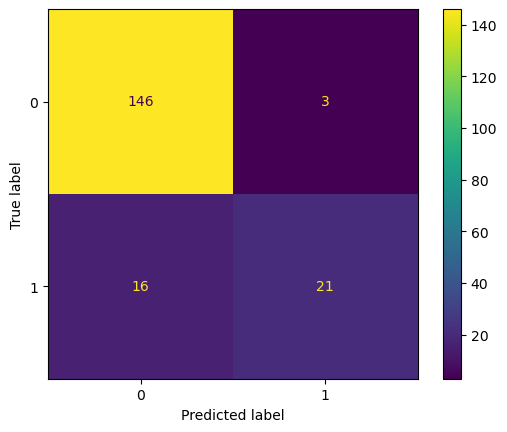

In [32]:
cm = confusion_matrix(y_test, preds, labels = rf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_2.classes_)
disp.plot()

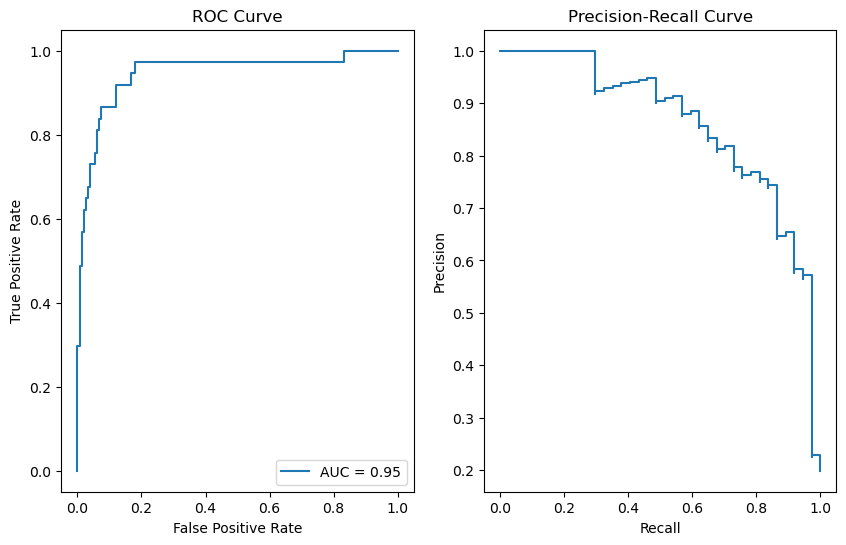

In [33]:
plot_roc_pr(rf_2, x_test, y_test)

0.23634623015873013


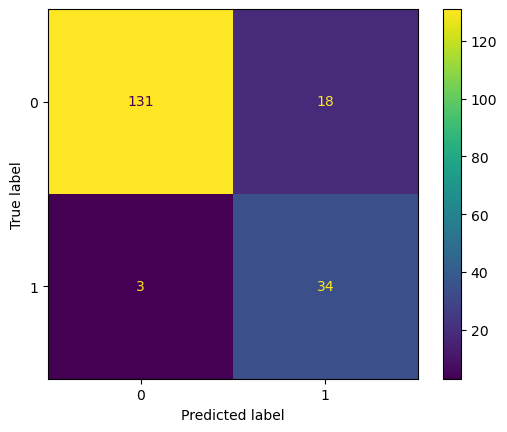

In [34]:
cutoff = roc_cutoff(rf_2, x_test, y_test)
print(cutoff)
y_pred = (rf_2.predict_proba(x_test)[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = rf_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_2_random.classes_)
disp.plot()

#### Feature Selection

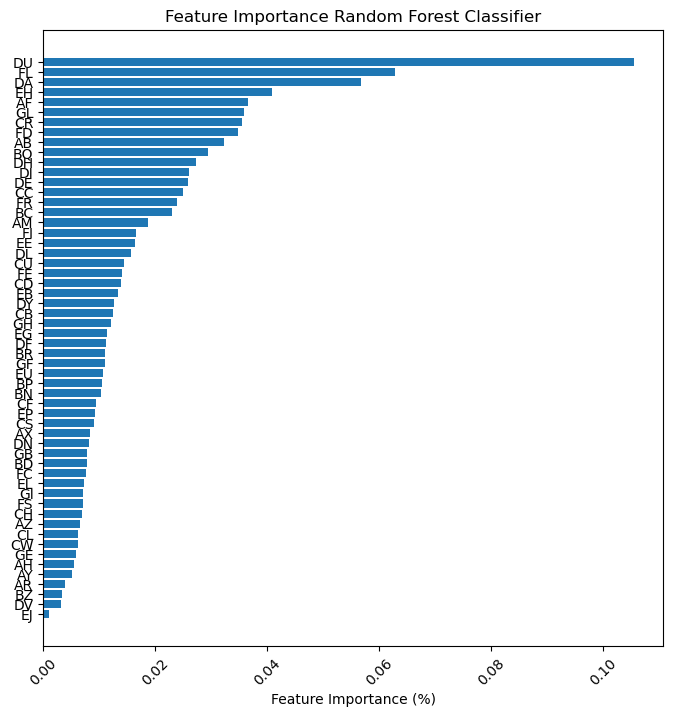

In [35]:
plot_feature_importance(X, rf_2,' Random Forest Classifier')
# feature_imp = pd.Series(rf_2.feature_importances_, index = x_train.columns.values).sort_values()
# plt.barh(feature_imp.index, feature_imp)

In [36]:
rf_feature_imp = pd.DataFrame(rf_2.feature_importances_, index = X.columns,  columns=['importance']).sort_values('importance', ascending=False)
rf_feature_imp[0:20].sum()

importance    0.688368
dtype: float64

In [37]:
cols = rf_feature_imp[0:20].index.values
# x_train[cols]
rf_3 = RandomForestClassifier(oob_score = True,
                              n_estimators = 1800,
                              min_samples_split = 2,
                              min_samples_leaf = 2,
                              max_depth = 150,
                              criterion = 'gini',
                              bootstrap = True,
                              random_state = 208)
rf_3.fit(x_train[cols], y_train)

preds = rf_3.predict(x_test[cols])
pred_prob = rf_3.predict_proba(x_test[cols])
print(rf_3.score(x_train[cols], y_train))
print(rf_3.score(x_test[cols], y_test))

0.9953596287703016
0.8978494623655914


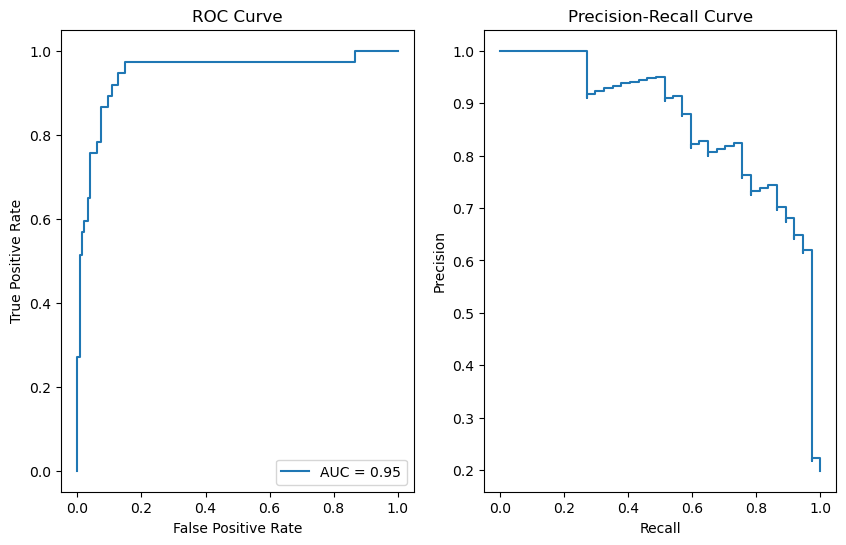

In [38]:
plot_roc_pr(rf_3, x_test[cols], y_test)

0.2439354056437391


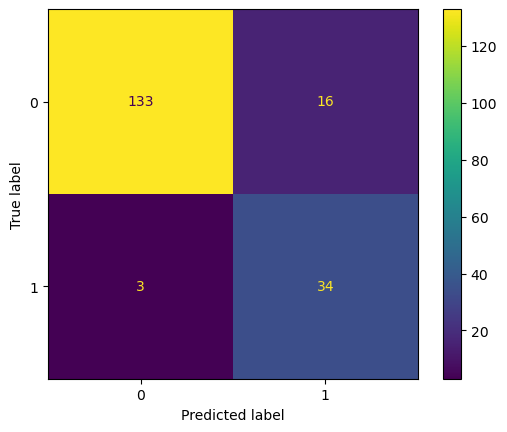

In [39]:
cutoff = roc_cutoff(rf_3, x_test[cols], y_test)
print(cutoff)
y_pred = (rf_3.predict_proba(x_test[cols])[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = rf_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_3.classes_)
disp.plot()

#### Weighted Random Forest

In [40]:
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'oob_score': oob}

rf_4 = RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 208)
rf_4_random = RandomizedSearchCV(estimator = rf_4,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5, refit = True,
                               verbose=2,
                               random_state = 208, n_jobs = -1, scoring = 'f1')
rf_4_random.fit(x_train, y_train)

preds = rf_4_random.predict(x_test)
print(rf_4_random.score(x_train, y_train))
print(rf_4_random.score(x_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.9793103448275862
0.7428571428571429


In [41]:
rf_4_random.best_params_

{'oob_score': True,
 'n_estimators': 2400,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_depth': 75,
 'criterion': 'entropy',
 'bootstrap': True}

In [42]:
rf_4 = RandomForestClassifier(oob_score = True,
                              n_estimators = 2400,
                              min_samples_split = 2,
                              min_samples_leaf = 5,
                              max_depth = 75,
                              criterion = 'entropy',
                              bootstrap = True,
                              random_state = 208)
rf_4.fit(x_train, y_train)

preds = rf_4.predict(x_test)
pred_prob = rf_4.predict_proba(x_test)
print(rf_4.score(x_train, y_train))
print(rf_4.score(x_test, y_test))

0.9860788863109049
0.8978494623655914


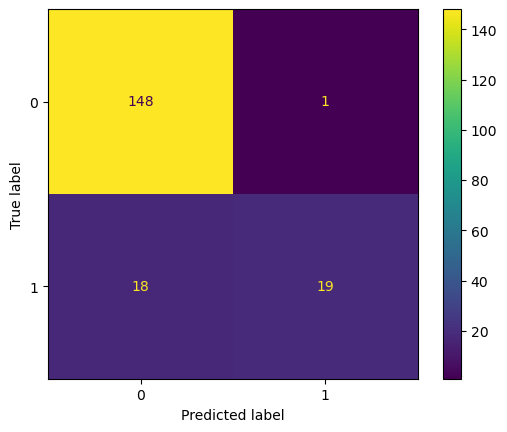

In [43]:
cm = confusion_matrix(y_test, preds, labels = rf_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_4.classes_)
disp.plot()

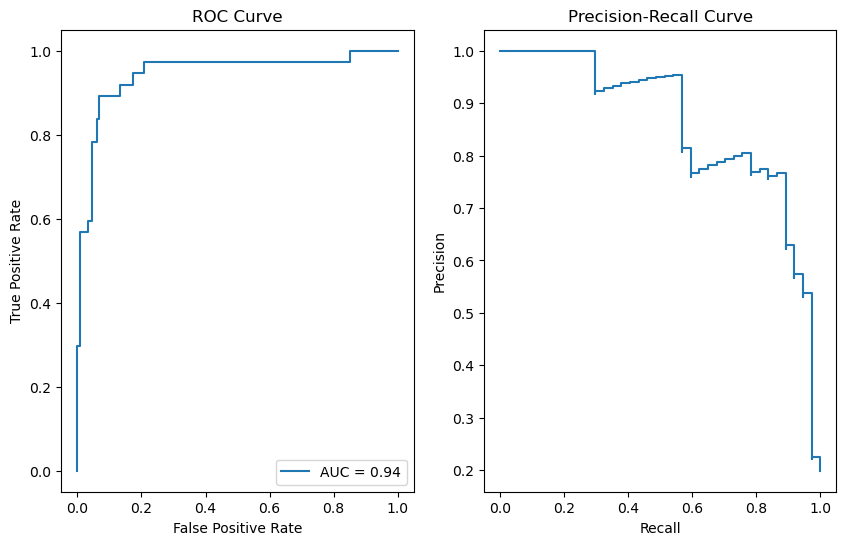

In [44]:
plot_roc_pr(rf_4, x_test, y_test)

0.2907133626661007


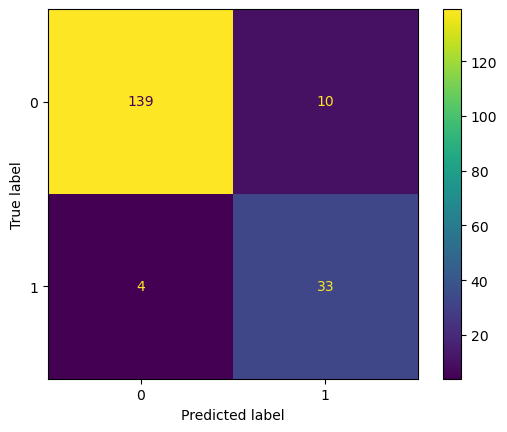

In [45]:
cutoff = roc_cutoff(rf_4, x_test, y_test)
print(cutoff)
y_pred = (rf_4.predict_proba(x_test)[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = rf_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_4.classes_)
disp.plot()

### XGBoost

In [46]:
xgb_1 = XGBClassifier(random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_1.fit(x_train, y_train)

preds = xgb_1.predict(x_test)
pred_prob = xgb_1.predict_proba(x_test)
print(xgb_1.score(x_train, y_train))
print(xgb_1.score(x_test, y_test))

1.0
0.9032258064516129


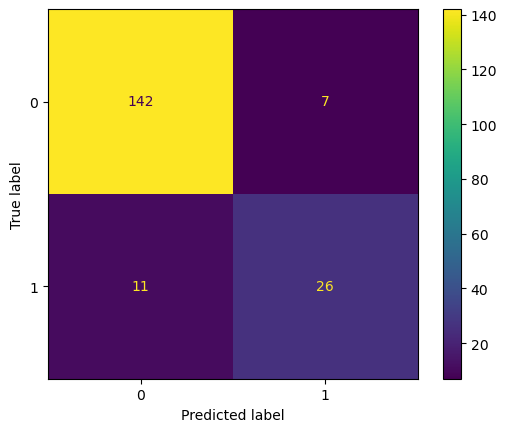

In [47]:
cm = confusion_matrix(y_test, preds, labels = xgb_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_1.classes_)
disp.plot()

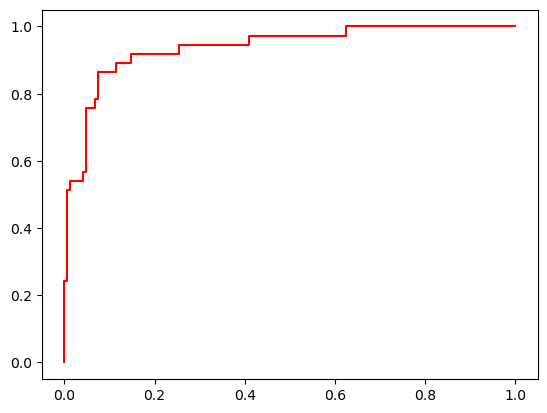

In [48]:
xgb_1_fpr, xgb_1_tpr, _ = roc_curve(y_test, pred_prob[:,1])
plt.plot(xgb_1_fpr, xgb_1_tpr, 'r', label = 'XGBoost')

In [49]:
param_grid = {
    "max_depth": [50, 75, 100, 150, 200],
    "learning_rate": [0.2, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 0.75, 1],
    "reg_lambda": [0, 1, 5, 10],
    "subsample": [0.5, 0.8],
    "colsample_bytree": [0.25, 0.5, 0.75],
}

xgb_2 = XGBClassifier(random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_2_random = RandomizedSearchCV(estimator = xgb_2,
                               param_distributions = param_grid,
                               n_iter = 30, cv = 5, refit = True,
                               verbose=2,
                               random_state=208, n_jobs = -1, scoring = 'f1')
xgb_2_fit = xgb_2_random.fit(x_train, y_train)

preds = xgb_2_fit.predict(x_test)
pred_prob = xgb_2_fit.predict_proba(x_test)
print(xgb_2_fit.score(x_train, y_train))
print(xgb_2_fit.score(x_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
1.0
0.7692307692307693


In [50]:
xgb_2_fit.best_params_

{'subsample': 0.8,
 'reg_lambda': 0,
 'max_depth': 150,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.75}

In [51]:
xgb_2 = XGBClassifier(subsample = 0.8,
                      reg_lambda = 0,
                      max_depth = 150,
                      learning_rate = 0.1,
                      gamma = 0,
                      colsample_bytree = 0.75,
                      random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_2.fit(x_train, y_train)

preds = xgb_2.predict(x_test)
pred_prob = xgb_2.predict_proba(x_test)
print(xgb_2.score(x_train, y_train))
print(xgb_2.score(x_test, y_test))

1.0
0.9193548387096774


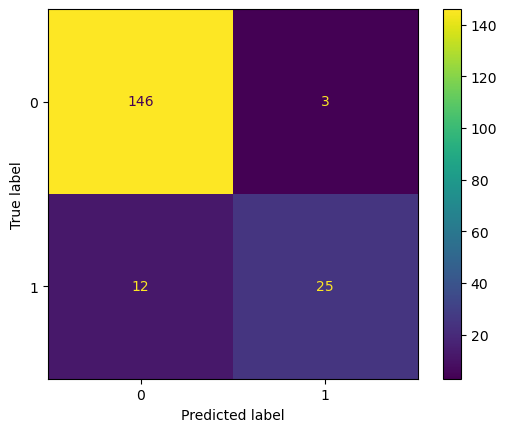

In [52]:
cm = confusion_matrix(y_test, preds, labels = xgb_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_2_random.classes_)
disp.plot()

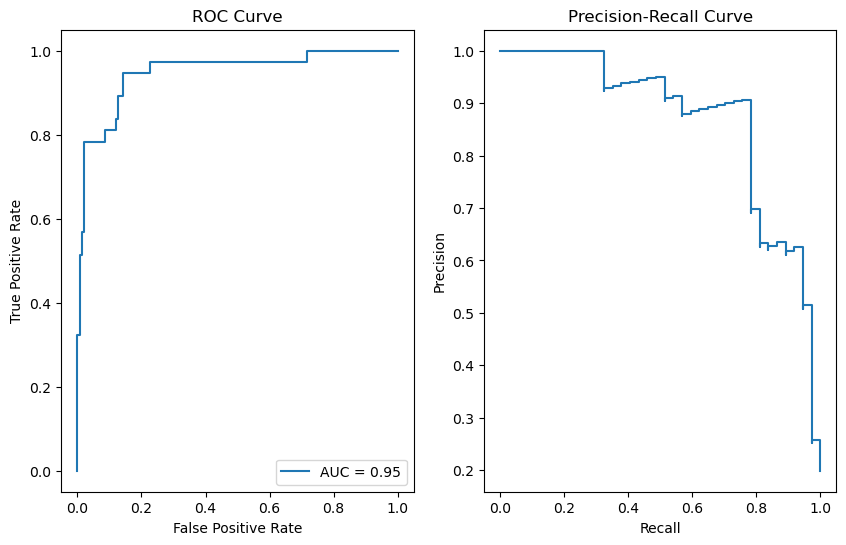

In [53]:
plot_roc_pr(xgb_2, x_test, y_test)

0.07442336


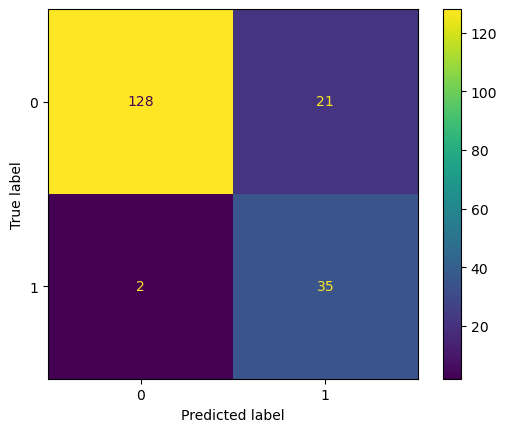

In [54]:
cutoff = roc_cutoff(xgb_2, x_test, y_test)
print(cutoff)
y_pred = (xgb_2.predict_proba(x_test)[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = xgb_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_2_random.classes_)
disp.plot()

#### Feature Selection

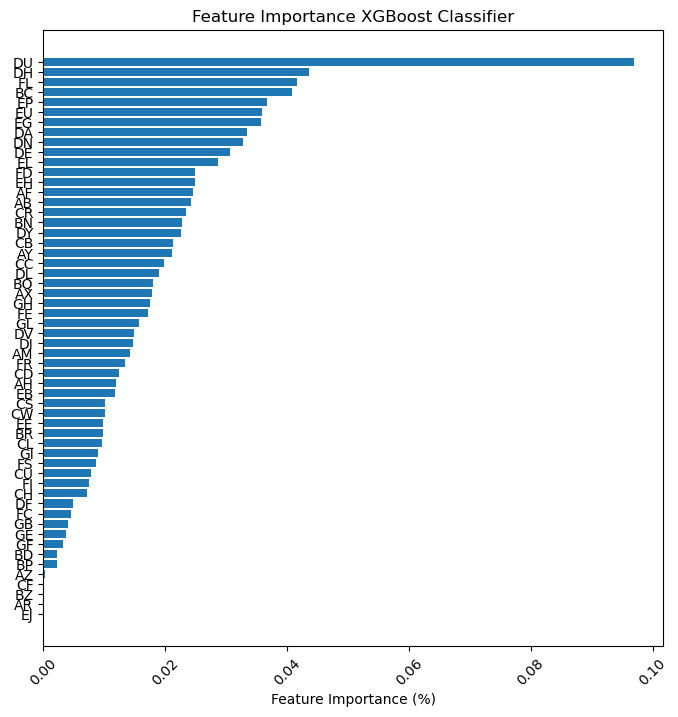

In [55]:
plot_feature_importance(X, xgb_2,' XGBoost Classifier')

In [56]:
xgb_feature_imp = pd.DataFrame(xgb_2.feature_importances_, index = X.columns,  columns=['importance']).sort_values('importance', ascending=False)
xgb_feature_imp[0:20].sum()

importance    0.66647
dtype: float32

In [57]:
cols = xgb_feature_imp[0:20].index.values
# x_train[cols]
xgb_3 = XGBClassifier(subsample = 0.8,
                      reg_lambda = 0,
                      max_depth = 150,
                      learning_rate = 0.1,
                      gamma = 0,
                      colsample_bytree = 0.75,
                      random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_3.fit(x_train[cols], y_train)

preds = xgb_3.predict(x_test[cols])
pred_prob = xgb_3.predict_proba(x_test[cols])
print(xgb_3.score(x_train[cols], y_train))
print(xgb_3.score(x_test[cols], y_test))

1.0
0.8978494623655914


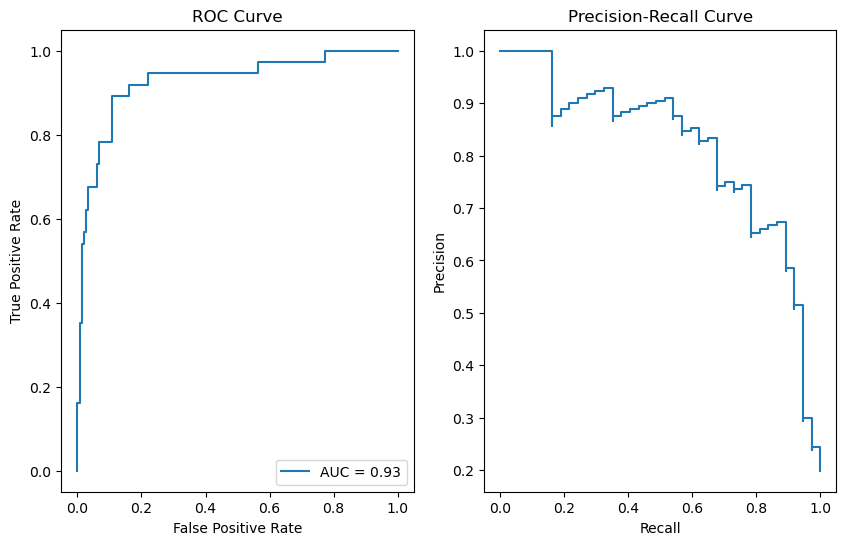

In [58]:
plot_roc_pr(xgb_3, x_test[cols], y_test)

0.094585024


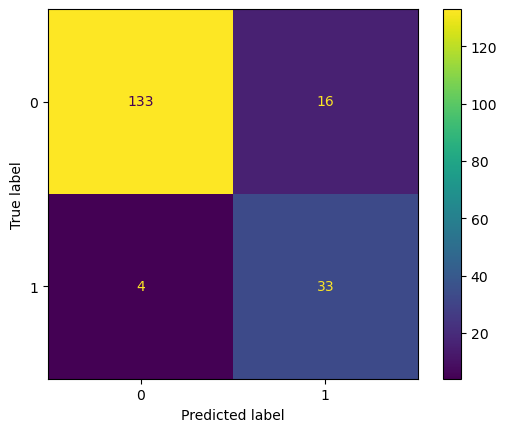

In [59]:
cutoff = roc_cutoff(xgb_3, x_test[cols], y_test)
print(cutoff)
y_pred = (xgb_3.predict_proba(x_test[cols])[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = xgb_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_3.classes_)
disp.plot()

#### Weighted XGBoost

In [60]:
param_grid = {
    "max_depth": [50, 75, 100, 150, 200],
    "learning_rate": [0.2, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 0.75, 1],
    "reg_lambda": [0, 1, 5, 10],
    "subsample": [0.5, 0.8],
    "colsample_bytree": [0.25, 0.5, 0.75],
}

# print((len(y_train)-sum(y_train))/sum(y_train))
xgb_4 = XGBClassifier(scale_pos_weight = 5, random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_4_random = RandomizedSearchCV(estimator = xgb_4,
                               param_distributions = param_grid,
                               n_iter = 30, cv = 5, refit = True,
                               verbose=2,
                               random_state=208, n_jobs = -1, scoring = 'f1')
xgb_4_fit = xgb_4_random.fit(x_train, y_train)

preds = xgb_4_fit.predict(x_test)
pred_prob = xgb_4_fit.predict_proba(x_test)
print(xgb_4_fit.score(x_train, y_train))
print(xgb_4_fit.score(x_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
1.0
0.7777777777777778


In [61]:
xgb_4_fit.best_params_

{'subsample': 0.5,
 'reg_lambda': 5,
 'max_depth': 100,
 'learning_rate': 0.2,
 'gamma': 0.25,
 'colsample_bytree': 0.5}

In [62]:
xgb_2 = XGBClassifier(subsample = 0.5,
                      reg_lambda = 5,
                      max_depth = 100,
                      learning_rate = 0.2,
                      gamma = 0.25,
                      colsample_bytree = 0.5,
                      scale_pos_weight = 5, random_state = 208, gpu_id = 0, predictor = 'gpu_predictor')
xgb_2.fit(x_train, y_train)

preds = xgb_2.predict(x_test)
pred_prob = xgb_2.predict_proba(x_test)
print(xgb_2.score(x_train, y_train))
print(xgb_2.score(x_test, y_test))

1.0
0.9139784946236559


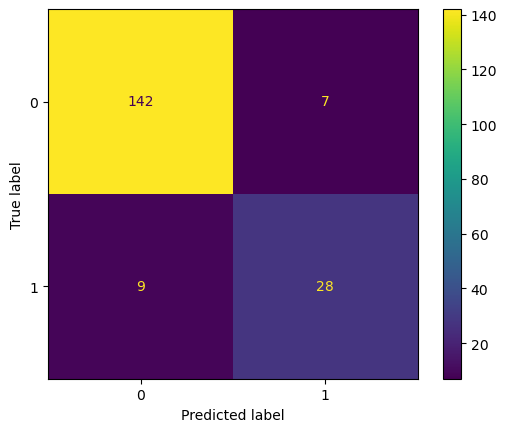

In [63]:
cm = confusion_matrix(y_test, preds, labels = xgb_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_2_random.classes_)
disp.plot()

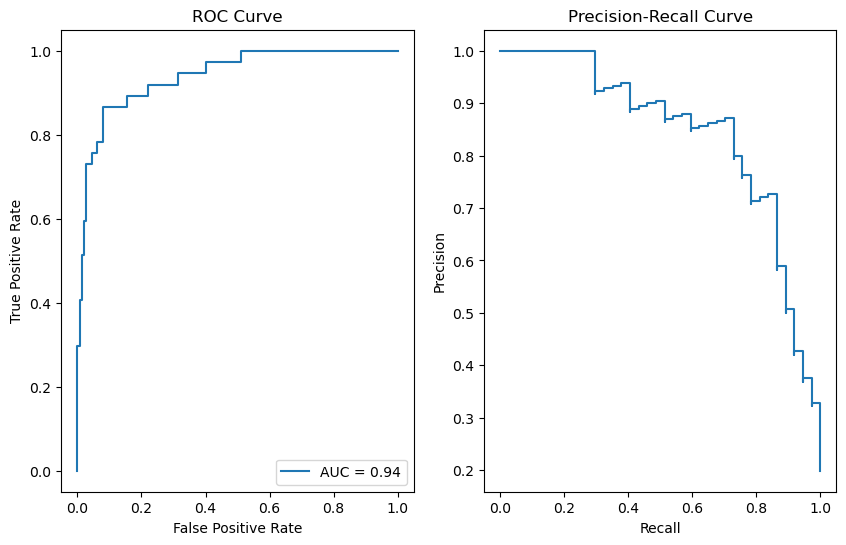

In [64]:
plot_roc_pr(xgb_2, x_test, y_test)

0.24369003


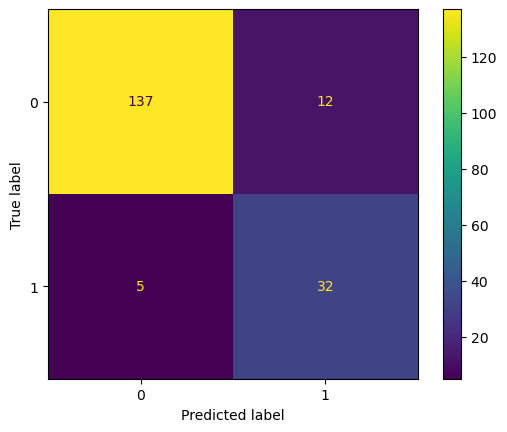

In [65]:
cutoff = roc_cutoff(xgb_2, x_test, y_test)
print(cutoff)
y_pred = (xgb_2.predict_proba(x_test)[:,1] >= cutoff).astype(bool)
cm = confusion_matrix(y_test, y_pred, labels = xgb_2_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_2_random.classes_)
disp.plot()